In [63]:
# Libraries

from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [64]:
# Create list of all targets (minus background noise)
dataset_path = '../data_speech_commands_v0.02'
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)
target_number = len(all_targets)
print(f'Number of labels: {target_number}')  

['right', 'eight', 'cat', 'tree', 'backward', 'learn', 'bed', 'happy', 'go', 'dog', 'no', 'wow', 'follow', 'nine', 'left', 'stop', 'three', 'sheila', 'one', 'bird', 'zero', 'seven', 'up', 'visual', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on', 'five', 'forward', 'off', 'four']
Number of labels: 35


In [95]:
# Settings
feature_sets_path = '/Users/clementpoisson/Desktop/CNN_MQTT_UFPR/builded_files'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = '../builded_files/all_targets_model.h5'
wake_word = 'stop'

In [66]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [67]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = np.zeros((len(feature_sets['y_train']), len(all_targets)))
y_train[:,0] = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = np.zeros((len(feature_sets['y_val']), len(all_targets)))
y_val[:,0] = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = np.zeros((len(feature_sets['y_test']), len(all_targets)))
y_test[:,0] = feature_sets['y_test']

In [68]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(77533, 16, 16)
(9663, 16, 16)
(9660, 16, 16)
(77533, 35)
(9663, 35)
(9660, 35)


In [69]:
# Peek at labels
print(y_val)


[[31.  0.  0. ...  0.  0.  0.]
 [33.  0.  0. ...  0.  0.  0.]
 [20.  0.  0. ...  0.  0.  0.]
 ...
 [30.  0.  0. ...  0.  0.  0.]
 [ 3.  0.  0. ...  0.  0.  0.]
 [32.  0.  0. ...  0.  0.  0.]]


In [70]:
# Convert ground truth arrays to one wake word
for word in all_targets:
    wake_word_index = all_targets.index(word)
    print(f"{wake_word_index} = {word}")
    for i in range(len(y_train[:,0])):
        if y_train[i,0] == wake_word_index :
            y_train[i,:] = np.zeros((1, len(all_targets)))
            y_train[i,wake_word_index] = 1.0

    for i in range(len(y_val[:,0])):
        if y_val[i,0] == wake_word_index :
            y_val[i,:] = np.zeros((1, len(all_targets)))
            y_val[i,wake_word_index] = 1.0

    for i in range(len(y_test[:,0])):
        if y_test[i,0] == wake_word_index :
            y_test[i,:] = np.zeros((1, len(all_targets)))
            y_test[i,wake_word_index] = 1.0

0 = right
1 = eight
2 = cat
3 = tree
4 = backward
5 = learn
6 = bed
7 = happy
8 = go
9 = dog
10 = no
11 = wow
12 = follow
13 = nine
14 = left
15 = stop
16 = three
17 = sheila
18 = one
19 = bird
20 = zero
21 = seven
22 = up
23 = visual
24 = marvin
25 = two
26 = house
27 = down
28 = six
29 = yes
30 = on
31 = five
32 = forward
33 = off
34 = four


In [71]:
# Peek at labels after conversion
print(y_val)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [72]:
# What percentage of 'stop' appear in validation labels
print(f"Percentage of Stop : {sum(y_val[:,15]) / len(y_val[:,15])}")
print(f"Percentage of Eight : {sum(y_val[:,1]) / len(y_val[:,1])}")

Percentage of Stop : 0.037772948359722655
Percentage of Eight : 0.07347614612439202


In [73]:
# View the dimensions of our input data
print(x_train.shape)

(77533, 16, 16)


In [74]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77533, 16, 16, 1)
(9663, 16, 16, 1)
(9660, 16, 16, 1)


In [75]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [76]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(target_number, activation='sigmoid'))

In [77]:
# Display model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 15, 15, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 32)          4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 64)        

In [78]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [79]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
776/776 [==============================] - 8s 9ms/step - loss: 0.1388 - acc: 0.1330 - val_loss: 0.0984 - val_acc: 0.2836
Epoch 2/30
776/776 [==============================] - 7s 9ms/step - loss: 0.0966 - acc: 0.3257 - val_loss: 0.0803 - val_acc: 0.4356
Epoch 3/30
776/776 [==============================] - 7s 9ms/step - loss: 0.0844 - acc: 0.4176 - val_loss: 0.0705 - val_acc: 0.5113
Epoch 4/30
776/776 [==============================] - 7s 9ms/step - loss: 0.0773 - acc: 0.4744 - val_loss: 0.0651 - val_acc: 0.5689
Epoch 5/30
776/776 [==============================] - 7s 9ms/step - loss: 0.0718 - acc: 0.5170 - val_loss: 0.0577 - val_acc: 0.6330
Epoch 6/30
776/776 [==============================] - 8s 10ms/step - loss: 0.0675 - acc: 0.5535 - val_loss: 0.0576 - val_acc: 0.6205
Epoch 7/30
776/776 [==============================] - 7s 10ms/step - loss: 0.0639 - acc: 0.5818 - val_loss: 0.0532 - val_acc: 0.6630
Epoch 8/30
776/776 [==============================] - 7s 10ms/step - loss:

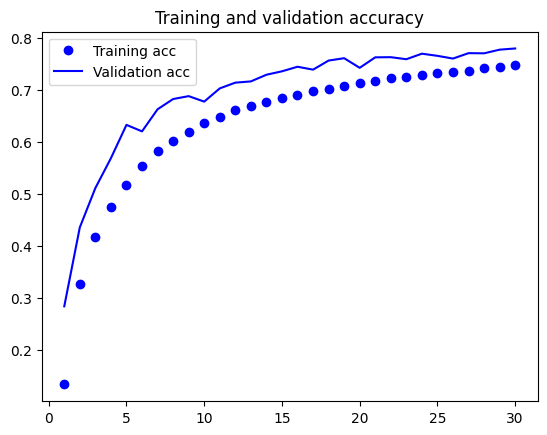

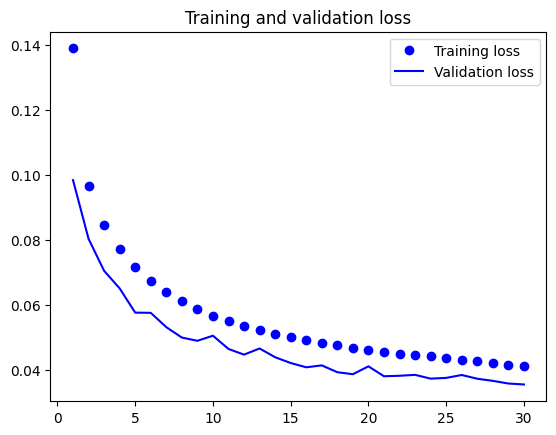

In [80]:
# Plot results


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [96]:
# Save the model as a file
models.save_model(model, model_filename)

In [97]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y[15] == 1:
        print(idx)

12
88
129
188
199
218
242
256
288
301
309
368
393
431
438
488
496
526
551
633
667
694
744
770
772
875
894
927
928
931
989
995
1015
1019
1057
1128
1159
1191
1211
1323
1341
1412
1460
1462
1499
1512
1539
1541
1548
1553
1557
1602
1607
1664
1686
1689
1732
1743
1748
1784
1789
1813
1820
1822
1835
1908
1915
1918
1926
1931
1939
1969
2006
2029
2041
2043
2102
2132
2146
2170
2182
2183
2257
2266
2292
2307
2346
2363
2420
2429
2433
2446
2493
2559
2566
2597
2623
2631
2635
2647
2674
2679
2815
2831
2838
2860
2887
2894
2930
2934
2959
2966
2982
2991
2996
3007
3010
3030
3037
3063
3192
3197
3200
3212
3263
3265
3294
3302
3310
3311
3314
3349
3366
3384
3421
3428
3430
3465
3471
3518
3531
3540
3627
3699
3719
3731
3764
3767
3789
3799
3891
3948
3977
4026
4173
4255
4261
4265
4271
4277
4287
4309
4310
4315
4381
4386
4420
4447
4483
4506
4520
4533
4535
4539
4563
4642
4643
4650
4651
4735
4740
4784
4790
4796
4806
4890
4928
4936
4963
4973
4983
4995
5010
5023
5039
5058
5135
5155
5221
5269
5277
5299
5306
5309
5327
5471
5489

In [98]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

1/1 [==============================] - 0s 155ms/step
Answer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  Prediction: [[5.3104743e-12 3.8473419e-05 2.7733196e-10 9.4068078e-08 4.6488879e-09
  7.4602460e-05 1.8033813e-06 2.2426386e-04 3.4708225e-09 8.4952326e-08
  8.9662862e-08 4.6994880e-10 4.7064335e-09 8.6178052e-01 3.1689600e-09
  6.3102373e-10 3.2843158e-07 3.1497899e-10 3.1728516e-05 2.8605177e-07
  1.5763668e-10 4.4853578e-04 8.9889324e-10 2.0871081e-10 2.1214033e-03
  6.3786321e-10 2.4440987e-12 6.8800745e-07 2.9740592e-11 3.7109118e-11
  3.9885435e-05 4.9578142e-03 1.2976265e-10 8.8389521e-12 4.4385003e-11]]
1/1 [==============================] - 0s 32ms/step
Answer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  Prediction: [[3.2891179e-04 8.8521317e-03 1.7773583e-04 4.8553250e-03 3.3545054e-03
  2.2000374e-02 1.7892102e-03 1.0390981e-02 2.4478200e-03 7

In [99]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

302/302 [==============================] - 1s 2ms/step - loss: 0.0355 - acc: 0.7748


[0.03547253459692001, 0.7748447060585022]